In [ ]:
import math
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :]

    return img

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Image shape: (1, 341, 512, 3)


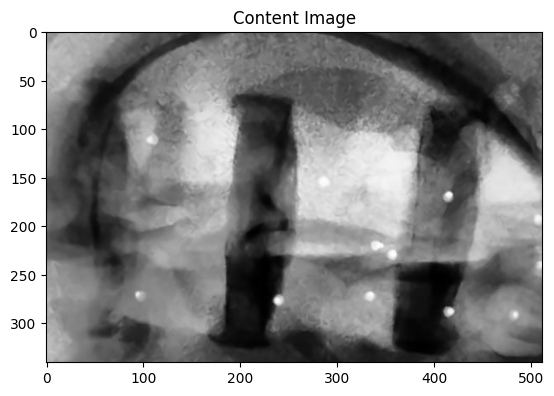

In [ ]:
content_path = 'AP.jpg' #C-arm image path
op_path = 'op200.png' #Output image path
content_image = load_img(content_path)
op_image = load_img(op_path)
print('Image shape:', content_image.shape)
imshow(content_image, 'Content Image')

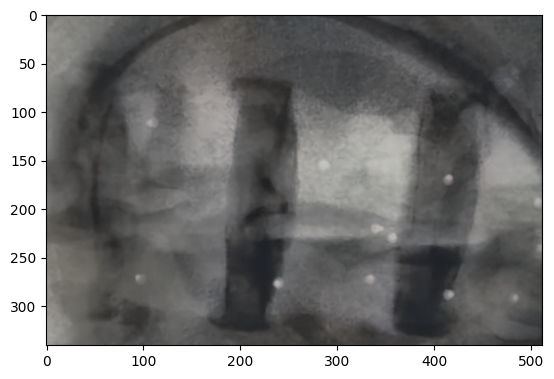

In [ ]:
imshow(op_image)

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (310,310))
x1 = tf.keras.applications.vgg19.preprocess_input(op_image*255)
x1 = tf.image.resize(x1, (310,310))
# load pretrained network(VGG19)
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

574710816/574710816 [==============================] - 7s 0us/step


'\nprediction_probabilities = vgg(x)\nprediction_probabilities.shape\n'

In [ ]:
plt.figure(figsize=(16,16))
#Extract only the required convolutional block
model = tf.keras.Model(inputs=[vgg.input], outputs=vgg.layers[2].output)
model.summary()
# preprocess input
content_image = tf.keras.applications.vgg19.preprocess_input(content_image*255)
content_image = tf.image.resize(content_image, (224,224))
op_image = tf.keras.applications.vgg19.preprocess_input(op_image*255)
op_image = tf.image.resize(op_image, (224,224))


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
Total params: 38720 (151.25 KB)
Trainable params: 38720 (151.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Figure size 1600x1600 with 0 Axes>

1/1 [==============================] - 0s 158ms/step
<class 'numpy.ndarray'>


(224, 224, 64)

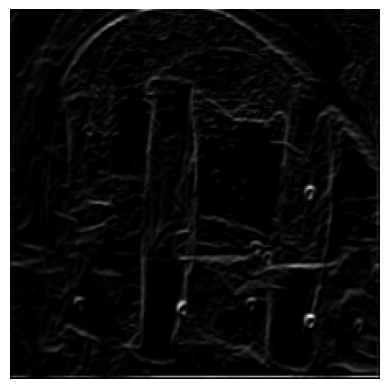

In [ ]:
#Obtain all feature maps of the content image
feature_cmaps = model.predict(content_image)
print(type(feature_cmaps)) #type is numpy.ndarray
content_maps = np.zeros((224,224,64))
square = 8
ix = 1
for i in range(feature_cmaps.shape[3]):
  plt.axis('off')
  plt.imshow(feature_cmaps[0, :, :, ix-1], cmap='gray')
  content_maps[:, :, ix - 1] = feature_cmaps[0, :, :, ix - 1]
  ix += 1
#plt.show()
content_maps.shape

1/1 [==============================] - 0s 86ms/step
<class 'numpy.ndarray'>


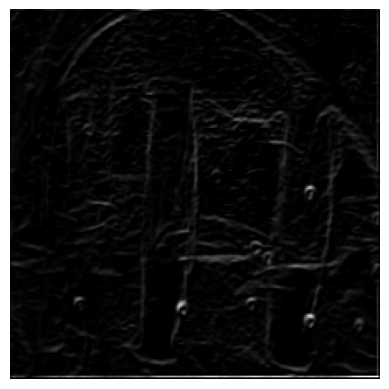

(1, 224, 224, 64)

In [ ]:
#Obtain all feature maps of the output image
feature_smaps = model.predict(op_image)
print(type(feature_smaps))
op_maps = np.zeros((224,224,64))
square = 8
ix = 1
for i in range(feature_smaps.shape[3]):
  plt.imshow(feature_smaps[0, :, :, ix-1], cmap='gray')
  plt.axis('off')
  op_maps[ :, :, ix - 1]=feature_smaps[0, :, :, ix - 1]
  ix += 1
plt.show()
feature_smaps.shape

In [ ]:
#Ensure there are no undefined values
initial_content_nans = np.isnan(content_maps).sum()
initial_op_nans = np.isnan(op_maps).sum()
print("Initial number of NaNs in content_maps:", initial_content_nans)
print("Initial number of NaNs in op_maps:", initial_op_nans)

Initial number of NaNs in content_maps: 0
Initial number of NaNs in op_maps: 0


In [ ]:
#normalize feature maps
epsilon = 1e-11
def normalize_feature_maps(feature_maps, name=""):
    normalized_maps = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[-1]):
        fmap = feature_maps[:, :, i]
        mean = np.mean(fmap)
        std = np.std(fmap)
        if std < epsilon:
            std = epsilon  # Avoid division by zero
        normalized_maps[:, :, i] = (fmap - mean) / std
    return normalized_maps

In [ ]:
content_maps = normalize_feature_maps(content_maps, name="content_maps")
op_maps = normalize_feature_maps(op_maps, name="op_maps")

In [ ]:
print("Range of content_maps:", np.min(content_maps), np.max(content_maps))
print("Range of op_maps:", np.min(op_maps), np.max(op_maps))

Range of content_maps: -6.6676737383626214 62.90883163959176
Range of op_maps: -5.185164346870374 212.04035462478976


In [ ]:
#compute the SAD values between the respective feature maps of the content and output image
sad_values = []

for i in range(feature_cmaps.shape[3]):
  #fmap1 = content_maps[:, :, i]
  #fmap2 = op_maps[:, :, i]
  denominator = feature_cmaps.shape[1]*feature_cmaps.shape[2]
  sad = np.sum(np.abs(op_maps[:, :, i] - content_maps[:, :, i]))/denominator
  sad_values.append(sad)
print(sad_values)
mean_sad = np.mean(sad_values)
print(mean_sad)


[0.4844677146454603, 0.4524726389977594, 0.43782493054515875, 0.6675490625992027, 0.6664595820195511, 0.4015757387986793, 0.34801451777097253, 0.6829977238281512, 0.24134338293733815, 0.4009873140835344, 0.38893780789296845, 0.3660771371686074, 0.3310827235519399, 0.6137812883289138, 0.4647599152753884, 0.3627406804734339, 0.4617186891833903, 0.5369172168332176, 0.33990241714168884, 0.18339401090500249, 0.5104103016244458, 0.38895834846733257, 0.44220028168642256, 0.4053540621744153, 0.3409218929746601, 0.5828984883128753, 0.5590952921738964, 0.5670639247771595, 0.5384704252307735, 0.5258890525893829, 0.6055796355876152, 0.42377995462898016, 0.5970205424595351, 0.4062468363073951, 0.5139878202243224, 0.4222529581802061, 0.30902628362562035, 0.5621487588928195, 0.482727829423403, 0.5356984484798553, 0.44194497971713365, 0.2672177729206918, 0.408406420469981, 0.3877294397079596, 0.329259239188133, 0.4996641465559175, 0.3409646484534541, 0.4426904674952576, 0.576207363972931, 0.5770192012

In [ ]:
sad_values = np.array(sad_values)
print("SAD values range:", sad_values.min(), "to", sad_values.max())

SSIM values range: 0.13155756657300618 to 0.7208413795694392


In [ ]:
#Use to filter outliers if needed
filtered_sad_values = sad_values[(sad_values >= -1) & (sad_values <= 1)]
mean_sad = np.mean(filtered_sad_values)
print(f"Mean SAD: {mean_sad}")
out_of_range_values = sad_values[(sad_values < -1) | (sad_values > 1)]
print(f"Out of range SAD values: {out_of_range_values}")

Mean SAD: 0.29849444965262756
Out of range SAD values: []


0.1471167545579352


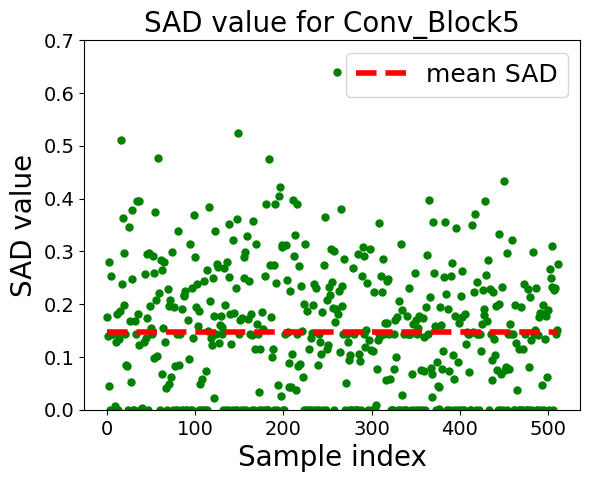

In [ ]:
a1 = np.array(sad_values)
mean = np.mean(a1)
print(mean)
plt.plot(a, marker='o', linestyle='', color='g', markersize=5)
x = list(itertools.islice(itertools.count(0),512))
y = [mean] * 512
plt.plot(x, y, linestyle='--', color='r', lw = '4', label = 'mean SAD' )  # Plot the chart
plt.ylim([0, 0.7])
plt.xlabel('Sample index', fontsize=20)
plt.ylabel('SAD value', fontsize=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('SAD value for Conv_Block5', fontsize=20)
plt.legend(loc='upper right', fontsize=18)
plt.show()